_Problem Statement_: `To build a Machine Learning Model to predict the paymentdate of an invoice when it gets created in the system`

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error



In [2]:
#Readind the csv file and showing 1st 5 rows of data
df = pd.read_csv('dataset.csv')
df.head()

business_code cust_number       name_customer           clear_date  \
0          U001  0200357714              US  in  2020-02-03 00:00:00   
1          U001  0200769623  WAL-MAR associates  2019-12-06 00:00:00   
2          U001  0200148860          DOLLA corp                  NaN   
3          U001  0200739006             AL corp                  NaN   
4          U001  0200755701           ASSOCI co                  NaN   

   business_year        doc_id posting_date  document_create_date  \
0         2020.0  1.930329e+09   2019-12-30              20191228   
1         2019.0  1.930194e+09   2019-11-26              20191126   
2         2020.0  1.930606e+09   2020-03-05              20200305   
3         2020.0  1.930727e+09   2020-04-01              20200331   
4         2020.0  1.930829e+09   2020-04-28              20200427   

   document_create_date_1  due_in_date invoice_currency document_type  \
0                20191230   20200131.0              USD            RV   
1                20191126   20191211.0              USD            RV   
2                20200305   20200320.0              USD            RV   
3                20200401   20200416.0              USD            RV   
4                20200428   20200513.0              USD            RV   

   posting_id  area_business  total_open_amount  baseline_create_date  \
0         1.0            NaN           84670.50            20191230.0   
1         1.0            NaN            1017.41            20191126.0   
2         1.0            NaN           11099.81            20200305.0   
3         1.0            NaN           66977.57            20200401.0   
4         1.0            NaN           36209.70            20200428.0   

  cust_payment_terms    invoice_id  is_open  
0               NA32  1.930329e+09        0  
1               NAH4  1.930194e+09        0  
2               NAA8  1.930606e+09        1  
3               NAA8  1.930727e+09        1  
4               NAA8  1.930829e+09        1

In [3]:
#Dimensions
df.shape

(50000, 19)

In [4]:
#concise summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   business_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date_1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document_type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

In [5]:
#Percentage of duplicates attributes
(df.duplicated().sum() / len(df)) * 100

2.324

In [6]:
#dropping duplicates
df.drop_duplicates(keep='first', inplace=True)

__Observations__

1. There are 50K rows out of which 2.324% are duplicates.
2. We've 19 features/columns.

## 1. Feature Analysis

#### 1.1 business_code

- company code of the account

In [7]:
#sum of null values in this columns
df.business_code.isna().sum()

0

In [8]:
# relative frequency by dividing all unique values by the sum of  values.
df.business_code.value_counts(normalize=True)

U001    0.907572
CA02    0.077952
U013    0.011200
U002    0.002928
U005    0.000225
U007    0.000123
Name: business_code, dtype: float64

__Observations__

1. `business_code` is a categorical feature.
2. It contains 6 unique values with heavy imbalance.

#### 1.2 cust_number

- customer number given to all the customers of the Account

In [9]:
#sum of null values in this columns
df.cust_number.isna().sum()

0

In [10]:
#percentage of relative frequency of number of unique values
df.cust_number.value_counts(normalize=True) * 100

0200769623    23.002580
0200726979     3.763463
0200762301     3.140997
0200759878     2.809288
0200794332     2.266678
                ...    
0140103385     0.002048
0200400124     0.002048
140106249      0.002048
0200735741     0.002048
0100035260     0.002048
Name: cust_number, Length: 1431, dtype: float64

__Observations__

1. `cust_number` is a categorical feature.
2. It can be used for customer identification.
3. There are 1431 unique customers.

#### 1.3 name_customer

- name of the customer. 

In [11]:
#sum of null values in this columns
df.name_customer.isna().sum()

0

In [12]:
#percentage of relative frequency of number of unique values
df.name_customer.value_counts(normalize=True) * 100

WAL-MAR llc         2.324010
WAL-MAR in          2.303534
WAL-MAR systems     2.301487
WAL-MAR us          2.260535
WAL-MAR             2.240059
                      ...   
TAP co              0.002048
COLOME in           0.002048
GOLD corporation    0.002048
VILA in             0.002048
SUN RI systems      0.002048
Name: name_customer, Length: 4214, dtype: float64

In [13]:
df[['cust_number', 'name_customer']].groupby(['cust_number']).groups

{'0100000048': [19274], '0100000051': [3986, 6183, 20566, 24541], '0100000158': [5579, 11602, 17554, 29231, 35476], '0100000161': [3540], '0100000217': [27682, 37527], '0100000222': [287, 1031, 2164, 2692, 3154, 3426, 6334, 11189, 13899, 15810, 15929, 16764, 17223, 17309, 17867, 18216, 19541, 21472, 21493, 21641, 22150, 22658, 23183, 24375, 24485, 25986, 27435, 28544, 29113, 31663, 34111, 34704, 35009, 35826, 37771, 38221, 38795, 40762, 42033, 44263, 49104], '0100000492': [12072], '0100000533': [31772, 35081, 43655, 47421], '0100000582': [1349], '0100000933': [2764], '0100001196': [664, 846, 1296, 1686, 3214, 3632, 3671, 4952, 5350, 6448, 6450, 7715, 7770, 8201, 8676, 9127, 9898, 10377, 10417, 10737, 10794, 11175, 11253, 11896, 12165, 12435, 12439, 12937, 12990, 13799, 14344, 14626, 15537, 15624, 15822, 15830, 15956, 16003, 16501, 16538, 16758, 17199, 17402, 18512, 18555, 18578, 18720, 18926, 19196, 19307, 19498, 20334, 20564, 20922, 21996, 22313, 22524, 22708, 22948, 24650, 24992, 257

In [14]:
df[['cust_number', 'name_customer']].groupby(['cust_number', 'name_customer']).groups

{('0100000048', 'GEOR associates'): [19274], ('0100000051', 'GREE '): [3986, 24541], ('0100000051', 'GREE in'): [6183], ('0100000051', 'GREE systems'): [20566], ('0100000158', 'CASC associates'): [35476], ('0100000158', 'CASC corp'): [17554], ('0100000158', 'CASC in'): [11602, 29231], ('0100000158', 'CASC us'): [5579], ('0100000161', 'THE W trust'): [3540], ('0100000217', 'MRS S llc'): [27682], ('0100000217', 'MRS S us'): [37527], ('0100000222', 'SMITHFIE '): [1031, 17867, 18216, 38795], ('0100000222', 'SMITHFIE associates'): [17309, 24375, 31663, 34704, 42033], ('0100000222', 'SMITHFIE co'): [6334, 16764, 21472, 23183, 49104], ('0100000222', 'SMITHFIE corp'): [15810, 19541, 28544, 35826], ('0100000222', 'SMITHFIE corporation'): [2692, 24485, 34111], ('0100000222', 'SMITHFIE foundation'): [287, 3426, 11189, 25986, 40762], ('0100000222', 'SMITHFIE in'): [13899, 15929, 22658], ('0100000222', 'SMITHFIE llc'): [3154, 27435, 44263], ('0100000222', 'SMITHFIE systems'): [21493, 35009, 38221],

__Observations__

1. `cust_number` is a categorical feature.
2. It can be used for customer identification.
3. There are 4214 unique customers.
4. There are companies having multiple values for `name_customer` for a single `cust_number`.

#### 1.4 clear_date

- The date on which the customer clears an invoice, or in simple terms, they
make the full payment. 

In [15]:
#converting data type of 'clear_date'
df.clear_date = df.clear_date.astype(np.datetime64)

In [16]:
#Percentage of null values in this columns
(df.clear_date.isna().sum() / len(df)) * 100

19.82677423317908

In [17]:
#percentage of relative frequency of number of unique values
df.clear_date.value_counts(normalize=True) * 100

2019-11-12    0.697229
2019-10-15    0.674243
2019-05-31    0.638488
2019-09-03    0.625718
2019-12-02    0.615502
                ...   
2019-08-03    0.002554
2019-09-02    0.002554
2020-02-08    0.002554
2019-02-02    0.002554
2019-05-18    0.002554
Name: clear_date, Length: 401, dtype: float64

In [18]:
#minimum and maximum timestamp
df.clear_date.min(), df.clear_date.max()

(Timestamp('2019-01-07 00:00:00'), Timestamp('2020-05-21 00:00:00'))

__Observations__

1. Use of `clear_date` is unknown for now.
2. There's 19.82% of null values in the feature.

#### 1.5 buisness_year

- the year in which invoice was created

In [19]:
#sum of null values in this columns
df.business_year.isna().sum()

0

In [20]:
#percentage of relative frequency of number of unique values
df.business_year.value_counts(normalize=True) * 100

2019.0    69.529874
2020.0    30.470126
Name: business_year, dtype: float64

__Observations__

1. `business_year` is a categorical feature, use is unknown for now.

#### 1.6 doc_id

- It is also an unique identifier of an invoice is a primary key for
acct_doc_header table

In [21]:
#sum of null values in this columns
df.doc_id.isna().sum()

0

In [22]:
# relative frequency by dividing all unique values by the sum of  values.
df.doc_id.astype(int).value_counts(normalize=True)

-2147483648    0.077952
 1930713790    0.000020
 1928588182    0.000020
 1929051268    0.000020
 1930706201    0.000020
                 ...   
 1929221528    0.000020
 1930272153    0.000020
 1930005915    0.000020
 1929686431    0.000020
 1929373709    0.000020
Name: doc_id, Length: 45032, dtype: float64

__Observations__

1. Use of `doc_id` is unknown for now.

#### 1.7 posting_date

In [23]:
#converting data type of 'posting_data'
df.posting_date = df.posting_date.astype(np.datetime64)

In [24]:
#sum of null values in this columns
df.posting_date.isna().sum()

0

In [25]:
#percentage of relative frequency of number of unique values
df.posting_date.value_counts(normalize=True) * 100

2020-03-24    0.405422
2020-03-25    0.403374
2020-03-26    0.401327
2020-03-04    0.393136
2020-03-27    0.393136
                ...   
2019-12-27    0.008190
2020-05-13    0.006143
2020-05-14    0.004095
2019-12-28    0.002048
2020-05-17    0.002048
Name: posting_date, Length: 500, dtype: float64

__Observations__

1. Usage of `posting_date` is unknown for now.

#### 1.8 document_create_date

- The date on which the invoice document was created

In [26]:
#sum of null values in this columns
df.document_create_date.isna().sum()

0

In [27]:
#converting data type of 'document_create_date'
df.document_create_date = df.document_create_date\
                            .astype(str)\
                            .apply(lambda date: pd.to_datetime(f"{date[:4]}-{date[4:6]}-{date[6:]}", yearfirst=True, format="%Y-%m-%d"))

In [28]:
#percentage of relative frequency of number of unique values
df.document_create_date.value_counts(normalize=True) * 100

2020-03-24    0.429993
2020-03-20    0.389041
2020-03-25    0.386994
2020-03-23    0.382899
2020-04-01    0.382899
                ...   
2020-05-13    0.004095
2019-12-25    0.002048
2020-05-14    0.002048
2020-05-15    0.002048
2019-12-21    0.002048
Name: document_create_date, Length: 503, dtype: float64

__Observations__

1. Usage of `document_create_date` is unknown for now.

#### 1.9 document_create_date_1

- Normalised date of the invoice document

In [29]:
#sum of null values in this columns
df.document_create_date_1.isna().sum()

0

In [30]:
#correlation between 'document_create_date' and 'document_create_date_1'
df[['document_create_date', 'document_create_date_1']].corr()

document_create_date_1
document_create_date_1                     1.0

__Observations__

1. Dropping `document_create_date_1` due to very high correlation to `document_create_date`.

#### 1.10 due_in_date

- The date on which the customer is expected to clear an invoice

In [31]:
#sum of null values in this columns
df.due_in_date.isna().sum()

0

In [32]:
#converting data type of 'due_in_date'
df.due_in_date = df.due_in_date\
                    .astype(int)\
                    .astype(str)\
                    .apply(lambda date: pd.to_datetime(f"{date[:4]}-{date[4:6]}-{date[6:]}", yearfirst=True, format="%Y-%m-%d"))

In [33]:
#percentage of relative frequency of number of unique values
df.due_in_date.value_counts(normalize=True) * 100

2020-04-08    0.454564
2020-04-11    0.440231
2020-03-24    0.403374
2020-04-09    0.399279
2020-04-24    0.378803
                ...   
2019-01-09    0.002048
2020-07-02    0.002048
2020-07-04    0.002048
2020-06-28    0.002048
2020-07-08    0.002048
Name: due_in_date, Length: 551, dtype: float64

In [34]:
#Target variable
df['days_diff'] = (df.clear_date - df.due_in_date).dt.days

In [35]:
#mean of Target column
df.days_diff.mean(skipna=True)

0.90535052994509

In [36]:
#percentage of relative frequency of number of unique values
(df.days_diff.value_counts(normalize=True) * 100).head(10)

 0.0    21.560465
 1.0    12.202784
 2.0     9.641170
-5.0     7.559699
-4.0     6.821606
-1.0     6.206104
-3.0     5.383731
 3.0     5.337760
-2.0     4.272762
 4.0     3.258843
Name: days_diff, dtype: float64

In [37]:
#statistical data of 'days_diff'
df.days_diff.describe()

count    39155.000000
mean         0.905351
std         10.981674
min        -89.000000
25%         -3.000000
50%          0.000000
75%          2.000000
max        273.000000
Name: days_diff, dtype: float64

__Observations__

1. Usage of `due_in_date` is unknown for now.
2. The global average delay was 0.9 days.
3. 21.56% of the customers cleared their payment on date wheres 12.2% delayed the payment by 1 day.
4. 7.55% of the customers had payed 5 days in advance

#### 1.11 invoice_currency

- The currency of the invoice amount in the document for the invoice

In [38]:
#sum of null values in this columns
df.invoice_currency.isna().sum()

0

In [39]:
#percentage of relative frequency of number of unique values
df.invoice_currency.value_counts(normalize=True) * 100

USD    92.20484
CAD     7.79516
Name: invoice_currency, dtype: float64

__Observations__

1. Usage of `invoice_currency` is unknown for now.
2. 92.2% of the customers pay in USD.
3. Payments in CAD might've to be converted to USD later.

#### 1.12 document_type

- It represents the type of document. eg D1 represents Invoice

In [40]:
#sum of null values in this columns
df.document_type.isna().sum()

0

In [41]:
#percentage of relative frequency of number of unique values
df.document_type.value_counts(normalize=True) * 100

RV    99.99181
X2     0.00819
Name: document_type, dtype: float64

__Observations__

1. Usage of `document_type` is unknown for now.
2. 99.99% of the customers' `document_type` is RV

#### 1.13 posting_id

- key indicator to identify whether an AR item is invoice, deduction, credit
memo based on its value. Apllicable for SAP ERP 

In [42]:
#sum of null values in this columns
df.posting_id.isna().sum()

0

In [43]:
#percentage of relative frequency of number of unique values
df.posting_id.value_counts(normalize=True)*100

1.0    100.0
Name: posting_id, dtype: float64

__Observations__

1. The feature `posting_id` has a single value of 1 through out.

#### 1.14 area_business

- Business area in sap is defined as an organisational area within the financial
accounting module.

In [44]:
#percentage of null values in this columns
(df.area_business.isna().sum() / len(df)) * 100

100.0

__Observations__

1. The feature `area_business` has 100% null values

#### 1.15 total_open_amount

- The amount that is yet to be paid for that invoice 

In [45]:
#sum of null values in this columns
df.total_open_amount.isna().sum()

0

In [46]:
#converting amount of invoice_currency=CAD and storing all amount data in 'total_open_amount_usd'
CAD_TO_USD_CONV_RATIO = 0.813

df['total_open_amount_usd'] = df.total_open_amount
cad_indexes = df[df.invoice_currency == 'CAD'].index
df.loc[cad_indexes, 'total_open_amount_usd'] = df.loc[cad_indexes, 'total_open_amount_usd'] * CAD_TO_USD_CONV_RATIO

In [47]:
#statistical data of 'total_open_amount_usd'
df.total_open_amount_usd.describe(percentiles=np.arange(0, 1, 0.1))

count     48838.000000
mean      31319.845207
std       36929.811603
min           0.770000
0%            0.770000
10%         837.025000
20%        2973.416000
30%        7041.228000
40%       12666.480000
50%       17228.850000
60%       25256.110000
70%       38898.758000
80%       54318.386000
90%       79959.028413
max      730985.290000
Name: total_open_amount_usd, dtype: float64

In [48]:
#correlation between 'days_diff','total_open_amount_usd'
df[['days_diff', 'total_open_amount_usd']].corr()

days_diff  total_open_amount_usd
days_diff               1.000000               0.003932
total_open_amount_usd   0.003932               1.000000

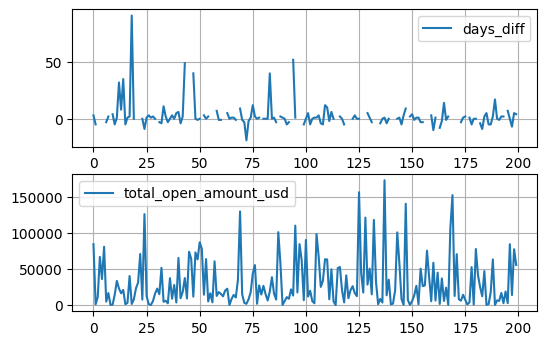

In [49]:
#finding a relation between  'days_diff','total_open_amount_usd'
fig, (ax0, ax1) = plt.subplots(2, 1, dpi=100)

df.head(200).days_diff.plot(ax=ax0, legend=True, grid=True)
df.head(200).total_open_amount_usd.plot(ax=ax1, legend=True, grid=True)

plt.show()

__Observations__

1. The feature `total_open_amount_usd` is an ordinal feature.
2. The lowest amount was 0.77 USD while the highest was 730,985 USD.
3. No correlation between `days_diff` & `total_open_amount_usd`.

#### 1.16 baseline_create_date

- The date on which the Invoice was created. 

In [50]:
#sum of null values in this columns
df.baseline_create_date.isna().sum()

0

In [51]:
#converting data type of 'baseline_create_date'
df.baseline_create_date = df.baseline_create_date\
                            .astype(int)\
                            .astype(str)\
                            .apply(lambda date: pd.to_datetime(f"{date[:4]}-{date[4:6]}-{date[6:]}", yearfirst=True, format="%Y-%m-%d"))

In [52]:
#percentage of relative frequency of number of unique values
df.baseline_create_date.value_counts(normalize=True) * 100

2020-04-01    0.518039
2020-03-16    0.466850
2020-04-16    0.452516
2019-03-01    0.411565
2019-05-16    0.409517
                ...   
2020-05-17    0.002048
2018-12-16    0.002048
2018-12-18    0.002048
2019-12-24    0.002048
2019-12-22    0.002048
Name: baseline_create_date, Length: 503, dtype: float64

__Observations__

1. Usage of `baseline_create_date` is unknown for now.

#### 1.17 cust_payment_terms

- Business terms and agreements between customers and accounts on
discounts and days of payment

In [53]:
#sum of null values in this columns
df.cust_payment_terms.isna().sum()

0

In [54]:
#percentage of relative frequency of number of unique values
df.cust_payment_terms.value_counts(normalize=True) * 100

NAA8    40.171588
NAH4    27.329129
CA10     7.600639
NAC6     3.521848
NAM4     2.674147
          ...    
NATJ     0.002048
NAUW     0.002048
NATH     0.002048
C129     0.002048
NATK     0.002048
Name: cust_payment_terms, Length: 73, dtype: float64

__Observations__

1. Usage of `cust_payment_terms` is unknown for now.
2. 40.17% of the customers have `NAA8`.

#### 1.18 invoice_id

- Unique number assigned when a seller creates an Invoice.

In [55]:
#sum of null values in this columns
df.invoice_id.isna().sum()

4

In [56]:
#percentage of relative frequency of number of unique values
df.invoice_id.value_counts(normalize=True) * 100

1.930547e+09    0.002048
1.930240e+09    0.002048
1.928633e+09    0.002048
1.929702e+09    0.002048
1.929658e+09    0.002048
                  ...   
1.930828e+09    0.002048
1.928907e+09    0.002048
1.930757e+09    0.002048
1.930777e+09    0.002048
1.929996e+09    0.002048
Name: invoice_id, Length: 48834, dtype: float64

__Observations__

1. Usage of `invoice_id` is unknown for now.

#### 1.19 is_open

- indicator of whether an invoice is open or closed. isopen = 1, means the
invoice is open. 

In [57]:
#sum of null values in this columns
df.is_open.isna().sum()

0

In [58]:
#percentage of relative frequency of number of unique values
df.is_open.value_counts(normalize=True) * 100

0    80.173226
1    19.826774
Name: is_open, dtype: float64

__Observations__

1. Usage of `is_open` is unknown for now.
2. 19.82% of the customers haven't cleared the invoice amount.

## 2.  Feature engineering


### 2.1 Constant variables

In [59]:
vs_constant = VarianceThreshold(threshold=0)

In [60]:
numerical = df[df.select_dtypes([np.number]).columns]

In [61]:
vs_constant.fit(numerical)

VarianceThreshold(threshold=0)

In [62]:
constant_columns = [column for column in numerical.columns
                    if column not in numerical.columns[vs_constant.get_support()]]

In [63]:
constant_cat_columns = [column for column in df.columns 
                        if (df[column].dtype == "O" and len(df[column].unique())  == 1 )]

In [64]:
#showing constant columns
all_constant_columns = constant_cat_columns + constant_columns
all_constant_columns

['posting_id', 'area_business']

In [65]:
#dropping constant columns
df.drop(labels=all_constant_columns, axis=1, inplace=True)

In [66]:
#Dimensions
df.shape

(48838, 19)

_observations_

1.There are two constant variable columns `posting_id` and `area_business`

## Quasi Constant

In [67]:
# make a threshold for quasi constant.
threshold = 0.98

# create empty list
quasi_constant_feature = []

In [68]:
#to show quasi constant
for feature in df.columns:

    # calculate the ratio.
    predominant = (df[feature].value_counts() / np.float(len(df))).sort_values(ascending=False).values[0]
    
    # append the column name if it is bigger than the threshold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
print(quasi_constant_feature)

['document_type']


In [69]:
#dropping quasi constant
df.drop(labels=quasi_constant_feature, axis=1, inplace=True)

In [70]:
#Dimensions
df.shape

(48838, 18)

### 3. Data Pre-Processing

 ##### 3.1Checking for null values

In [71]:
df.isnull().sum()

business_code                0
cust_number                  0
name_customer                0
clear_date                9683
business_year                0
doc_id                       0
posting_date                 0
document_create_date         0
document_create_date_1       0
due_in_date                  0
invoice_currency             0
total_open_amount            0
baseline_create_date         0
cust_payment_terms           0
invoice_id                   4
is_open                      0
days_diff                 9683
total_open_amount_usd        0
dtype: int64

_observations_

1.There are null values in `clear_date`, `invoice_id`,`days_diff`



#### 3.2 Removing Features

In [72]:
#Dropping 'total_open_amount' because we created a new column 'total_open_amount_usd'
df.drop('total_open_amount',inplace=True,axis=1)

In [73]:
#Dropping 'invoice_currency' because we converted all into USD 
df.drop('invoice_currency',inplace=True,axis=1)

In [74]:
#Dropping 'name_customer' because this and 'cust_id' are used to identify thr customer
df.drop('name_customer',inplace=True,axis=1)

In [75]:
#Dropping 'document_create_date_1' due to very high correlation to 'document_create_date'
df.drop('document_create_date_1',inplace=True,axis=1)

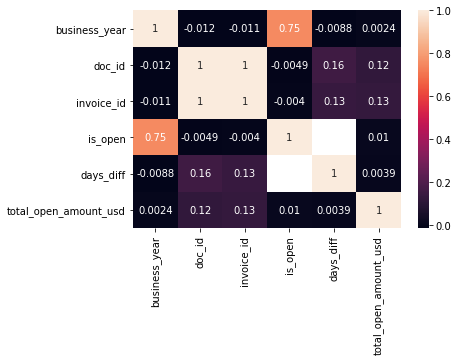

In [76]:
#Correlation in 'df.csv'
correlation = df.corr()
sns.heatmap(correlation, annot=True)
plt.show()

_observations_

1.`doc_id` and `invoice_id` are highly correlated

2.We can drop invoice_id

In [77]:
#Dropping 'invoice_id'
df.drop('invoice_id',inplace=True,axis=1)

In [78]:
#concise summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48838 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   business_code          48838 non-null  object        
 1   cust_number            48838 non-null  object        
 2   clear_date             39155 non-null  datetime64[ns]
 3   business_year          48838 non-null  float64       
 4   doc_id                 48838 non-null  float64       
 5   posting_date           48838 non-null  datetime64[ns]
 6   document_create_date   48838 non-null  datetime64[ns]
 7   due_in_date            48838 non-null  datetime64[ns]
 8   baseline_create_date   48838 non-null  datetime64[ns]
 9   cust_payment_terms     48838 non-null  object        
 10  is_open                48838 non-null  int64         
 11  days_diff              39155 non-null  float64       
 12  total_open_amount_usd  48838 non-null  float64       
dtypes

### 3.3 Splitting data

In [79]:
#Splitting data based on clear_date
splitting=df['clear_date'].notnull()
df_main=df[splitting]
df_null=df[~splitting]


In [80]:
#data types of volumns
df_main.dtypes

business_code                    object
cust_number                      object
clear_date               datetime64[ns]
business_year                   float64
doc_id                          float64
posting_date             datetime64[ns]
document_create_date     datetime64[ns]
due_in_date              datetime64[ns]
baseline_create_date     datetime64[ns]
cust_payment_terms               object
is_open                           int64
days_diff                       float64
total_open_amount_usd           float64
dtype: object

In [81]:
#Number of unique values in columns
df_main.nunique()

business_code                6
cust_number               1339
clear_date                 401
business_year                2
doc_id                   39155
posting_date               422
document_create_date       426
due_in_date                489
baseline_create_date       432
cust_payment_terms          70
is_open                      1
days_diff                  181
total_open_amount_usd    35641
dtype: int64

_observations_

1.`doc_id` has highest unique values

2.`business_code` has least unique values

In [82]:
#Dropping 'is_open' and 'business_year' 
df_main.drop(['is_open','business_year'],inplace=True,axis=1)

In [83]:
df_main.sort_values(by="posting_date",inplace=True,ignore_index=True)

### 3.4 Splitting data again

In [84]:
#storing delay column in Y and rest in X
X=df_main.drop('days_diff',axis=1)
Y=df_main.days_diff
X.drop(['clear_date'],inplace=True,axis=1)


In [85]:
#splitting data using sklearn
from sklearn.model_selection import train_test_split
X_train,X_inter_test,Y_train,Y_inter_test = train_test_split(X,Y,test_size=0.3,random_state=0 , shuffle = False)
X_val,X_test,Y_val,Y_test = train_test_split(X_inter_test,Y_inter_test,test_size=0.5,random_state=0 , shuffle = False)


In [86]:
X_train.shape , X_val.shape , X_test.shape

((27408, 9), (5873, 9), (5874, 9))

##  4.EDA

<AxesSubplot:xlabel='days_diff', ylabel='Density'>

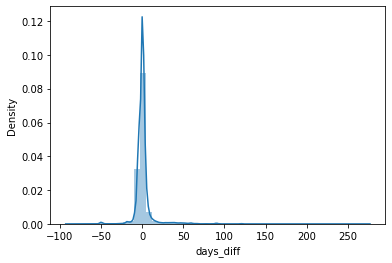

In [87]:
sns.distplot(Y)


_observations_

1.Maximum number of people paid on date 

2.It is a right skew

<AxesSubplot:xlabel='days_diff', ylabel='total_open_amount_usd'>

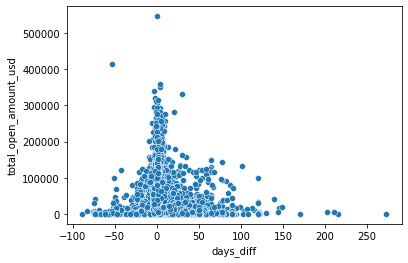

In [88]:
sns.scatterplot(data=X_train.merge(Y_train,on = X_train.index), x="days_diff", y="total_open_amount_usd")

_observations_

1.Highest paid customer clear its due on date




## 4 LABLE ENCODING

In [89]:
#Data types of data
X_train.dtypes 

business_code                    object
cust_number                      object
doc_id                          float64
posting_date             datetime64[ns]
document_create_date     datetime64[ns]
due_in_date              datetime64[ns]
baseline_create_date     datetime64[ns]
cust_payment_terms               object
total_open_amount_usd           float64
dtype: object

In [90]:
#converting all data typesto string for lable encoding
X_train.astype(str)
X_val.astype(str)
X_test.astype(str)

business_code cust_number        doc_id posting_date  \
33281          U001  0200714710  1930222049.0   2019-12-10   
33282          U001  0200750051  1930256797.0   2019-12-10   
33283          U001  0200769623  1930254275.0   2019-12-10   
33284          U001  0200752302  1930251913.0   2019-12-10   
33285          U001  0200739006  1930252584.0   2019-12-10   
...             ...         ...           ...          ...   
39150          U001  0200777735  1930577944.0   2020-02-27   
39151          CA02  0140106408  2960613769.0   2020-02-27   
39152          U001  0200943275  1930580919.0   2020-02-27   
39153          U001  0200759878  1930570543.0   2020-02-27   
39154          U001  0200789077  1930567309.0   2020-02-27   

      document_create_date due_in_date baseline_create_date  \
33281           2019-12-06  2019-12-25           2019-12-10   
33282           2019-12-10  2019-12-25           2019-12-10   
33283           2019-12-09  2019-12-25           2019-12-10   
33284           2019-12-09  2019-12-25           2019-12-10   
33285           2019-12-09  2019-12-25           2019-12-10   
...                    ...         ...                  ...   
39150           2020-02-27  2020-05-02           2020-02-27   
39151           2020-02-28  2020-03-10           2020-02-29   
39152           2020-02-27  2020-03-13           2020-02-27   
39153           2020-02-26  2020-03-13           2020-02-27   
39154           2020-02-25  2020-03-13           2020-02-27   

      cust_payment_terms total_open_amount_usd  
33281               NAA8              31043.64  
33282               NAA8              20346.42  
33283               NAH4               2235.64  
33284               NAA8               17103.9  
33285               NAA8               21300.0  
...                  ...                   ...  
39150               NAGD              47259.54  
39151               CA10    46889.157119999996  
39152               NAA8               37837.6  
39153               NAH4              11068.73  
39154               NAA8              31094.52  

[5874 rows x 9 columns]

In [91]:
#CONVERTING THE DATA FROM OBJECT TO INT
colnames = list(X_train.columns)
label_encoder = preprocessing.LabelEncoder() 
for col in colnames:
    if X_train[col].dtype==object:
        X_train[col]= label_encoder.fit_transform(X_train[col])

In [92]:
colnames = list(X_test.columns)
label_encoder = preprocessing.LabelEncoder() 
for col in colnames:
    if X_test[col].dtype==object:
        X_test[col]= label_encoder.fit_transform(X_test[col])

In [93]:
colnames = list(X_val.columns)
label_encoder = preprocessing.LabelEncoder() 
for col in colnames:
    if X_val[col].dtype==object:
        X_val[col]= label_encoder.fit_transform(X_val[col])

In [94]:
X_train.dtypes,'************************',X_test.dtypes,'************************',X_val.dtypes

(business_code                     int32
 cust_number                       int32
 doc_id                          float64
 posting_date             datetime64[ns]
 document_create_date     datetime64[ns]
 due_in_date              datetime64[ns]
 baseline_create_date     datetime64[ns]
 cust_payment_terms                int32
 total_open_amount_usd           float64
 dtype: object,
 '************************',
 business_code                     int32
 cust_number                       int32
 doc_id                          float64
 posting_date             datetime64[ns]
 document_create_date     datetime64[ns]
 due_in_date              datetime64[ns]
 baseline_create_date     datetime64[ns]
 cust_payment_terms                int32
 total_open_amount_usd           float64
 dtype: object,
 '************************',
 business_code                     int32
 cust_number                       int32
 doc_id                          float64
 posting_date             datetime64[ns]
 documen

_observations_

1.Objects changed to int

2.`datetime64` didnt changed its data type

In [95]:
#comparing posting_date and 'baseline_create_date'
X_train[['posting_date','baseline_create_date']]

posting_date baseline_create_date
0       2018-12-30           2018-12-30
1       2018-12-30           2018-12-30
2       2018-12-30           2018-12-30
3       2018-12-30           2018-12-30
4       2018-12-30           2018-12-30
...            ...                  ...
27403   2019-10-09           2019-10-09
27404   2019-10-09           2019-10-09
27405   2019-10-09           2019-10-09
27406   2019-10-09           2019-10-09
27407   2019-10-09           2019-10-09

[27408 rows x 2 columns]

_observations_

1.`posting_date` and `baseline_create_date` has same values 

2.so we can drop any one

In [96]:
#dropping baseline_create_date
X_train.drop(['baseline_create_date'], axis =1,inplace=True)
X_val.drop(['baseline_create_date'],axis=1 , inplace=True)
X_test.drop(['baseline_create_date'],axis=1 , inplace=True)

### 4. converting / splitting dates

In [97]:
#making a column of due_day_of_week from due_in_date
X_train['due_day_of_week'] = X_train['due_in_date'].dt.weekday 
X_val['due_day_of_week'] = X_val['due_in_date'].dt.weekday 
X_test['due_day_of_week'] = X_test['due_in_date'].dt.weekday

In [98]:
#making a column of due_day and due_month from due_in_date
X_train['due_day'] = X_train['due_in_date'].dt.day
X_train['due_month'] = X_train['due_in_date'].dt.month


X_val['due_day'] = X_val['due_in_date'].dt.day
X_val['due_month'] = X_val['due_in_date'].dt.month



X_test['due_day'] = X_test['due_in_date'].dt.day
X_test['due_month'] = X_test['due_in_date'].dt.month

In [99]:
#converting
X_val['posting_date']=pd.to_datetime(X_val['posting_date'])
X_test['posting_date']=pd.to_datetime(X_test['posting_date'])

In [100]:
#making a column of posting_day_of_week,posting_day,posting_month date from posting_date
X_train['posting_day_of_week'] = X_train['posting_date'].dt.weekday 
X_val['posting_day_of_week'] = X_val['posting_date'].dt.weekday 
X_test['posting_day_of_week'] = X_test['posting_date'].dt.weekday

X_train['posting_day'] = X_train['posting_date'].dt.day
X_train['posting_month'] = X_train['posting_date'].dt.month


X_val['posting_day'] = X_val['posting_date'].dt.day
X_val['posting_month'] = X_val['posting_date'].dt.month



X_test['posting_day'] = X_test['posting_date'].dt.day
X_test['posting_month'] = X_test['posting_date'].dt.month

In [101]:
#making a column of document_create_date_week,pdocument_create_date_day,pdocument_create_date_month from document_create_date
X_train['document_create_date_week'] = X_train['document_create_date'].dt.weekday 
X_val['document_create_date_week'] = X_val['document_create_date'].dt.weekday 
X_test['document_create_date_week'] = X_test['document_create_date'].dt.weekday

X_train['document_create_date_day'] = X_train['document_create_date'].dt.day
X_train['document_create_date_month'] = X_train['document_create_date'].dt.month


X_val['document_create_date_day'] = X_val['document_create_date'].dt.day
X_val['document_create_date_month'] = X_val['document_create_date'].dt.month



X_test['document_create_date_day'] = X_test['document_create_date'].dt.day
X_test['document_create_date_month'] = X_test['document_create_date'].dt.month

### 4.1 Dropping thye originial date columns

In [102]:
X_train.drop(['posting_date'], axis =1,inplace=True)
X_val.drop(['posting_date'],axis=1 , inplace=True)
X_test.drop(['posting_date'],axis=1 , inplace=True)



X_train.drop(['due_in_date'], axis =1,inplace=True)
X_val.drop(['due_in_date'],axis=1 , inplace=True)
X_test.drop(['due_in_date'],axis=1 , inplace=True)

X_train.drop(['document_create_date'], axis =1,inplace=True)
X_val.drop(['document_create_date'],axis=1 , inplace=True)
X_test.drop(['document_create_date'],axis=1 , inplace=True)


In [103]:
#checking its data types
X_train.dtypes,'************************',X_test.dtypes,'************************',X_val.dtypes

(business_code                   int32
 cust_number                     int32
 doc_id                        float64
 cust_payment_terms              int32
 total_open_amount_usd         float64
 due_day_of_week                 int64
 due_day                         int64
 due_month                       int64
 posting_day_of_week             int64
 posting_day                     int64
 posting_month                   int64
 document_create_date_week       int64
 document_create_date_day        int64
 document_create_date_month      int64
 dtype: object,
 '************************',
 business_code                   int32
 cust_number                     int32
 doc_id                        float64
 cust_payment_terms              int32
 total_open_amount_usd         float64
 due_day_of_week                 int64
 due_day                         int64
 due_month                       int64
 posting_day_of_week             int64
 posting_day                     int64
 posting_month     

_observations_

1.All features are in `int` or `float` as we needed

In [104]:
#Dimensions
X_train.shape

(27408, 14)

In [105]:
#columns
X_train.columns

Index(['business_code', 'cust_number', 'doc_id', 'cust_payment_terms',
       'total_open_amount_usd', 'due_day_of_week', 'due_day', 'due_month',
       'posting_day_of_week', 'posting_day', 'posting_month',
       'document_create_date_week', 'document_create_date_day',
       'document_create_date_month'],
      dtype='object')

In [106]:
#Passing a value of zero for the parameter will filter all the features with zero variance
constant_filter = VarianceThreshold(threshold=0)
#we need to simply apply this filter to our training set as shown in the following example
constant_filter.fit(X_train)
#the number of non-constant features.
len(X_train.columns[constant_filter.get_support()])

14

In [107]:
# transpose the feature matrice
X_train_T = X_train.T
# print the number of duplicated features
print(X_train_T.duplicated().sum())
# select the duplicated features columns names
duplicated_columns = X_train_T[X_train_T.duplicated()].index.values

0


## 5 Feature selection

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

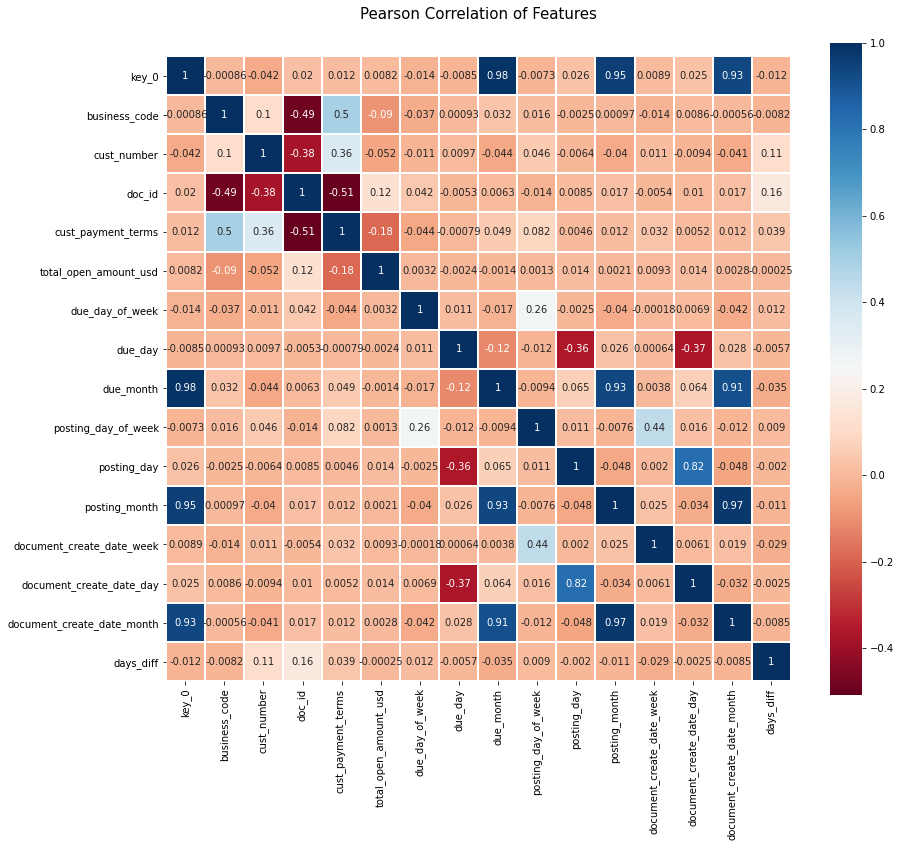

In [108]:
#finding correlation between featues
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.merge(Y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)



_observations_

1.No need to remove any column


##   5.1 selecting features

[14:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Importances :  [0.01253749 0.254414   0.01814219 0.33836058 0.03055205 0.14547926
 0.03626702 0.00208756 0.10521053 0.0172462  0.00110251 0.03595477
 0.00187709 0.00076871]


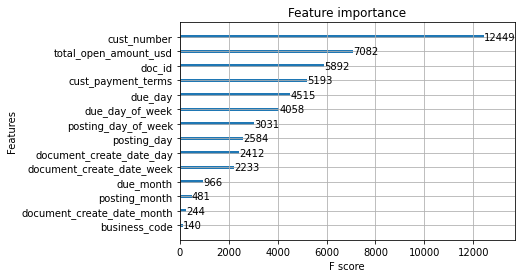

In [109]:
#making a graph on feature importance
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(X_train, Y_train)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

_observations_

1.The important features are `cust_payment_terms`,`due_day_of_week`,`due_day`,`total_open_amount_usd`,`cust_number`,`doc_id`,`posting_day`,`document_create_date_day`,`posting_day_of_week`,`due_month`

2.The least important feature is   `business_code`

In [110]:
#selecting all important features into a dataframe
selected_train=X_train[['cust_payment_terms','due_day_of_week','due_day','total_open_amount_usd','cust_number','doc_id','posting_day','document_create_date_day','posting_day_of_week','due_month']]
selected_val=X_val[['cust_payment_terms','due_day_of_week','due_day','total_open_amount_usd','cust_number','doc_id','posting_day','document_create_date_day','posting_day_of_week','due_month']]
selected_test=X_test[['cust_payment_terms','due_day_of_week','due_day','total_open_amount_usd','cust_number','doc_id','posting_day','document_create_date_day','posting_day_of_week','due_month']]

## 6 Modelling

In [111]:
#making 3 empty list for further visualization of models
Algorithm=[]
MSE_Score=[]
Accuracy=[]

### 6.1 Linear Regression

In [112]:
#Appending algorithm type for visualization
Algorithm.append('Linear Regression')
#initializing algorithm
base_model = LinearRegression()
#fitting the data in algorithm
base_model.fit(selected_train, Y_train)

LinearRegression()

In [113]:
# Predicting the Test Set Results
y_predict = base_model.predict(selected_val)

In [114]:
#Appending MSE for visualization
MSE_Score.append(round(mean_squared_error(Y_val, y_predict), 2))
#Appending Accuracy for gvisualization
Accuracy.append(base_model.score(selected_val,Y_val)) 

###  6.2 Tree Based Model


In [115]:
#Appending algorithm type for visualization
Algorithm.append('DecisionTree')

In [116]:
#initializing algorithm
regressor = DecisionTreeRegressor(random_state=0 , max_depth=5)

In [117]:
#fitting the data in algorithm
regressor.fit(selected_train, Y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [118]:
# Predicting the Test Set Results
y_predict2 = regressor.predict(selected_val)

In [119]:
#Appending MSE for visualization
MSE_Score.append(round(mean_squared_error(Y_val, y_predict2), 2))
#Appending Accuracy for gvisualization
Accuracy.append(regressor.score(selected_val,Y_val))

###  6.3 XGB regression

In [120]:
#Appending algorithm type for visualization
Algorithm.append('XGB')

In [121]:
#initializing algorithm
xgb_r = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)

In [122]:
#fitting the data in algorithm
xgb_r.fit(selected_train, Y_train)

[14:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# Predicting the Test Set Results
y_predict1 = xgb_r.predict(selected_val)

In [124]:
#Appending MSE for visualization
MSE_Score.append(round(mean_squared_error(Y_val, y_predict1), 2))
#Appending Accuracy for gvisualization
Accuracy.append(xgb_r.score(selected_val,Y_val))

###  6.4 SVM

In [125]:
#Appending algorithm type for visualization
Algorithm.append('SVM')

In [126]:
#initializing algorithm
svc=SVR()

In [127]:
#fitting the data in algorithm
svc.fit(selected_train, Y_train)

SVR()

In [128]:
# Predicting the Test Set Results
y_predict3 = svc.predict(selected_val)

In [129]:
#Appending MSE for visualization
MSE_Score.append(round(mean_squared_error(Y_val, y_predict3), 2))
#Appending Accuracy for gvisualization
Accuracy.append(svc.score(selected_val,Y_val))

In [130]:
#making a dataframe for visualization
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score,Accuracy)), columns = ['Algorithm', 'MSE_Score', 'Accuracy'])

In [131]:
Comparison

Algorithm  MSE_Score  Accuracy
0  Linear Regression      70.29 -0.538089
1       DecisionTree     137.54 -2.009934
2                XGB      95.57 -1.091330
3                SVM      45.01  0.015023

_observations_

1.`SVM` has least MSE_Score

2.`Decision Tree` has highest MSE_Score

3.`SVM` is ideal to use for this data set

## 7.The Lost Data

In [132]:
#null sum in this data
df_null.isnull().sum()

business_code               0
cust_number                 0
clear_date               9683
business_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
baseline_create_date        0
cust_payment_terms          0
is_open                     0
days_diff                9683
total_open_amount_usd       0
dtype: int64

In [133]:
#cincise information
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9683 entries, 2 to 49996
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   business_code          9683 non-null   object        
 1   cust_number            9683 non-null   object        
 2   clear_date             0 non-null      datetime64[ns]
 3   business_year          9683 non-null   float64       
 4   doc_id                 9683 non-null   float64       
 5   posting_date           9683 non-null   datetime64[ns]
 6   document_create_date   9683 non-null   datetime64[ns]
 7   due_in_date            9683 non-null   datetime64[ns]
 8   baseline_create_date   9683 non-null   datetime64[ns]
 9   cust_payment_terms     9683 non-null   object        
 10  is_open                9683 non-null   int64         
 11  days_diff              0 non-null      float64       
 12  total_open_amount_usd  9683 non-null   float64       
dtypes:

In [134]:
#concise information of selected_train
selected_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27408 entries, 0 to 27407
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cust_payment_terms        27408 non-null  int32  
 1   due_day_of_week           27408 non-null  int64  
 2   due_day                   27408 non-null  int64  
 3   total_open_amount_usd     27408 non-null  float64
 4   cust_number               27408 non-null  int32  
 5   doc_id                    27408 non-null  float64
 6   posting_day               27408 non-null  int64  
 7   document_create_date_day  27408 non-null  int64  
 8   posting_day_of_week       27408 non-null  int64  
 9   due_month                 27408 non-null  int64  
dtypes: float64(2), int32(2), int64(6)
memory usage: 3.1 MB


In [135]:
#making a dataframe with df_null by dropping unnecessary columns
X_main_test = df_null.drop(['business_year','clear_date','baseline_create_date','is_open','days_diff'],axis=1)
X_main_test


business_code cust_number        doc_id posting_date  \
2              U001  0200148860  1.930606e+09   2020-03-05   
3              U001  0200739006  1.930727e+09   2020-04-01   
4              U001  0200755701  1.930829e+09   2020-04-28   
5              U001  0200148860  1.930687e+09   2020-03-23   
8              U001  0200764795  1.930819e+09   2020-04-29   
...             ...         ...           ...          ...   
49990          U001  0200769623  1.930830e+09   2020-04-28   
49992          U001  0200792734  1.930683e+09   2020-03-21   
49993          U001  0200759878  1.930593e+09   2020-03-04   
49994          U001  0200793568  1.930663e+09   2020-03-17   
49996          CA02  0140104331  2.960619e+09   2020-03-04   

      document_create_date due_in_date cust_payment_terms  \
2               2020-03-05  2020-03-20               NAA8   
3               2020-03-31  2020-04-16               NAA8   
4               2020-04-27  2020-05-13               NAA8   
5               2020-03-23  2020-04-07               NAA8   
8               2020-04-23  2020-05-14               NAA8   
...                    ...         ...                ...   
49990           2020-04-27  2020-05-13               NAH4   
49992           2020-03-21  2020-04-05               NAA8   
49993           2020-03-02  2020-03-19               NAH4   
49994           2020-03-17  2020-04-01               NAA8   
49996           2020-03-04  2020-03-22               CA10   

       total_open_amount_usd  
2                11099.81000  
3                66977.57000  
4                36209.70000  
5                81104.63000  
8                  335.76000  
...                      ...  
49990             4025.34000  
49992            23294.11000  
49993            26395.50000  
49994            79769.47000  
49996             8235.89325  

[9683 rows x 8 columns]

In [136]:
#concise information
X_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9683 entries, 2 to 49996
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   business_code          9683 non-null   object        
 1   cust_number            9683 non-null   object        
 2   doc_id                 9683 non-null   float64       
 3   posting_date           9683 non-null   datetime64[ns]
 4   document_create_date   9683 non-null   datetime64[ns]
 5   due_in_date            9683 non-null   datetime64[ns]
 6   cust_payment_terms     9683 non-null   object        
 7   total_open_amount_usd  9683 non-null   float64       
dtypes: datetime64[ns](3), float64(2), object(3)
memory usage: 680.8+ KB


### 7.1 Feature engineering for lost data

-Label Encoding

-We have to make sure that this data and the data used for prediction should contain same columns 

In [137]:
#CONVERTING THE DATA FROM OBJECT TO INT
colnames = list(X_main_test.columns)
label_encoder = preprocessing.LabelEncoder() 
for col in colnames:
    if X_main_test[col].dtype==object:
        X_main_test[col]= label_encoder.fit_transform(X_main_test[col])

In [138]:
X_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9683 entries, 2 to 49996
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   business_code          9683 non-null   int32         
 1   cust_number            9683 non-null   int32         
 2   doc_id                 9683 non-null   float64       
 3   posting_date           9683 non-null   datetime64[ns]
 4   document_create_date   9683 non-null   datetime64[ns]
 5   due_in_date            9683 non-null   datetime64[ns]
 6   cust_payment_terms     9683 non-null   int32         
 7   total_open_amount_usd  9683 non-null   float64       
dtypes: datetime64[ns](3), float64(2), int32(3)
memory usage: 567.4 KB


In [139]:
#making a column of due_day_of_week,due_day and due_month from due_in_date
X_main_test['due_day_of_week'] = X_main_test['due_in_date'].dt.weekday 
X_main_test['due_day'] = X_main_test['due_in_date'].dt.day
X_main_test['due_month'] =X_main_test['due_in_date'].dt.month

In [140]:
#making a column of posting_day_of_week,posting_day and posting_month from posting_date
X_main_test['posting_day_of_week'] = X_main_test['posting_date'].dt.weekday 
X_main_test['posting_day'] = X_main_test['posting_date'].dt.day
X_main_test['posting_month'] = X_main_test['posting_date'].dt.month

In [141]:
#making a column of document_create_date_week',document_create_date_day and document_create_date_month from document_create_date
X_main_test['document_create_date_week'] = X_main_test['document_create_date'].dt.weekday 
X_main_test['document_create_date_day'] = X_main_test['document_create_date'].dt.day
X_main_test['document_create_date_month'] = X_main_test['document_create_date'].dt.month

In [142]:
#drop[ping unnecessary columns]
X_main_test.drop(['posting_date','document_create_date','due_in_date'],inplace=True,axis=1)

In [143]:
#checking columns
X_main_test.columns

Index(['business_code', 'cust_number', 'doc_id', 'cust_payment_terms',
       'total_open_amount_usd', 'due_day_of_week', 'due_day', 'due_month',
       'posting_day_of_week', 'posting_day', 'posting_month',
       'document_create_date_week', 'document_create_date_day',
       'document_create_date_month'],
      dtype='object')

In [144]:
#dropping more columns
X_main_test.drop(['business_code','posting_month','document_create_date_week', 'document_create_date_month'],inplace=True,axis=1)

In [145]:
#comparing columns in both datas
selected_train.columns,'************************', X_main_test.columns

(Index(['cust_payment_terms', 'due_day_of_week', 'due_day',
        'total_open_amount_usd', 'cust_number', 'doc_id', 'posting_day',
        'document_create_date_day', 'posting_day_of_week', 'due_month'],
       dtype='object'),
 '************************',
 Index(['cust_number', 'doc_id', 'cust_payment_terms', 'total_open_amount_usd',
        'due_day_of_week', 'due_day', 'due_month', 'posting_day_of_week',
        'posting_day', 'document_create_date_day'],
       dtype='object'))

In [146]:
#fitting regression in data
final_result = svc.predict(X_main_test)

In [147]:
#initializing
final_result = pd.Series(final_result,name='days_diff')

In [148]:
len(final_result)

9683

In [149]:
Col=pd.DataFrame()

In [150]:
final_result=final_result .astype(int)

In [151]:
days_diff=[]
for x in final_result:
    days_diff.append(pd.Timedelta(days=x))
Col['days_diff'] = days_diff
Col

days_diff
0       3 days
1       3 days
2       3 days
3       3 days
4       3 days
...        ...
9678    3 days
9679    3 days
9680    3 days
9681    3 days
9682    4 days

[9683 rows x 1 columns]

## End Game

In [152]:
Final=pd.DataFrame()
t =  df_null.copy()

In [153]:
t.shape

(9683, 13)

In [154]:
t.drop(columns = ['clear_date','days_diff'],inplace =True,axis=1)

In [155]:
Final = pd.concat([t,Col],axis=1)

In [156]:
Final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17480 entries, 0 to 49996
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   business_code          9683 non-null   object         
 1   cust_number            9683 non-null   object         
 2   business_year          9683 non-null   float64        
 3   doc_id                 9683 non-null   float64        
 4   posting_date           9683 non-null   datetime64[ns] 
 5   document_create_date   9683 non-null   datetime64[ns] 
 6   due_in_date            9683 non-null   datetime64[ns] 
 7   baseline_create_date   9683 non-null   datetime64[ns] 
 8   cust_payment_terms     9683 non-null   object         
 9   is_open                9683 non-null   float64        
 10  total_open_amount_usd  9683 non-null   float64        
 11  days_diff              9683 non-null   timedelta64[ns]
dtypes: datetime64[ns](4), float64(4), object(3), t

In [157]:
Final.head()

business_code cust_number  business_year        doc_id posting_date  \
0           NaN         NaN            NaN           NaN          NaT   
1           NaN         NaN            NaN           NaN          NaT   
2          U001  0200148860         2020.0  1.930606e+09   2020-03-05   
3          U001  0200739006         2020.0  1.930727e+09   2020-04-01   
4          U001  0200755701         2020.0  1.930829e+09   2020-04-28   

  document_create_date due_in_date baseline_create_date cust_payment_terms  \
0                  NaT         NaT                  NaT                NaN   
1                  NaT         NaT                  NaT                NaN   
2           2020-03-05  2020-03-20           2020-03-05               NAA8   
3           2020-03-31  2020-04-16           2020-04-01               NAA8   
4           2020-04-27  2020-05-13           2020-04-28               NAA8   

   is_open  total_open_amount_usd days_diff  
0      NaN                    NaN    3 days  
1      NaN                    NaN    3 days  
2      1.0               11099.81    3 days  
3      1.0               66977.57    3 days  
4      1.0               36209.70    3 days

# ************ THE END*************